<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# Projeto Final | Pipeline de Dados do Telegram


---

# **Tópicos**

<ol type="1">
  <li>Contexto;</li>
  <li>Dados;</li>
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Conclusões.</li>
</ol>

---

## 1\. Contexto

O atual projeto busca criar um pipeline de dados para, através de um **chatbot** fazer a extração, tratamento e análise de dados de uma conversa no Telegram.

Todos os prints das configurações tanto do Telegram, como nas plataformas AWS estão salvos neste [link](https://github.com/joaolucascv/pipeline-img.git) do Github. 


### **1.1. Chatbot**

Um **chatbot** é um tipo de software que interage com usuários através de conversas automatizadas em plataformas de mensagens. Uma aplicação comum de **chatbots** é o seu uso no atendimento ao cliente, onde, de maneira geral, ajudam clientes a resolver problemas ou esclarecer dúvidas recorrentes antes mesmo que um atendente humano seja acionado.

### **1.2. Telegram**

**Telegram** é uma plataforma de mensagens instantâneas *freeware* (distribuído gratuitamente) e, em sua maioria, *open source*. É muito popular entre desenvolvedores por ser pioneiro na implantação da funcionalidade de criação de **chatbots**, que, por sua vez, permitem a criação de diversas automações.

### **1.3. Objetivo**

Nesse projeto vamos criar um grupo no telegram e enviar mensagens para teste durante 3 dias. A captação dos dados via **chatbot** será feita diariamente. Ao final dessa atividade, vamos para a parte analítica. O objetivo do projeto é responder as seguintes perguntas:

1. Quantas mensagens cada usuário mandou por dia?
1. Qual a média do tamanho das mensagens enviadas por usuário por dia?
1. Qual a quantidade de mensagens por hora por dia da semana por número da semana?


Portanto, vamos construir um *pipeline* de dados que ingira, processe, armazene e exponha mensagens de um grupo do **Telegram** para que profissionais de dados possam realizar análises. A arquitetura proposta é dividida em duas: transacional, no **Telegram**, onde os dados são produzidos, e analítica, na Amazon Web Services (AWS), onde os dados são analisados.

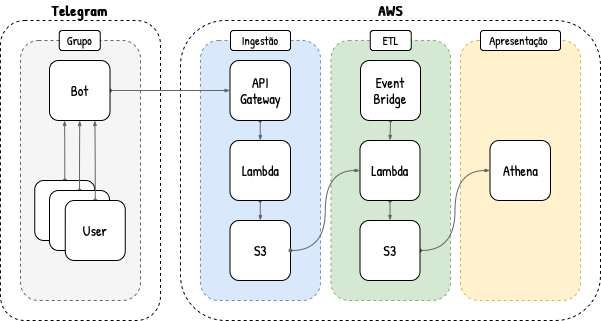

 - **Telegram**

O `Telegram` representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um *bot* e redirecionadas via *webhook* do *backend* do aplicativo para um *endpoint* (endereço *web* que aceita requisições HTTP) exposto pelo `AWS API Gateway`. As mensagens trafegam no corpo ou *payload* da requisição.

 - **AWS | Ingestão**

Uma requisição HTTP com o conteúdo da mensagem em seu *payload* é recebia pelo `AWS API Gateway` que, por sua vez, as redireciona para o `AWS Lambda`, servindo assim como seu gatilho. Já o `AWS Lambda` recebe o *payload* da requisição em seu parâmetro *event*, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o *payload*) e o armazena no `AWS S3` particionado por dia.

 - **AWS | ETL**

Uma vez ao dia, o `AWS Event Bridge` aciona o `AWS Lambda` que processa todas as mensagens do dia anterior (atraso de um dia ou D-1), denormaliza o dado semi-estruturado típico de arquivos no formato JSON, salva o conteúdo processado em um arquivo no formato Apache Parquet e o armazena no `AWS S3` particionado por dia.

 - **AWS | Apresentação**

Por fim, uma tabela do `AWS Athena` é apontada para o *bucket* do `AWS S3` que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de *insights*.

## 2\. Dados

As mensagens captadas por um *bot* podem ser acessadas via API. A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do *bot*.

In [1]:
##Iniciei usando a função getpass para proteger o token de acesso ao bot do telegram.

from getpass import getpass

token = getpass()

··········


In [2]:
# A url base é comum a todos os métodos da API.

import json
import requests

base_url = f'https://api.telegram.org/bot{token}'

In [3]:
# Vamos utilizar 2 métodos da API para interagir com a URL:

# getMe: para retornar informações sobre o nosso código.

response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

https://api.telegram.org/bot7807025868:AAHejeJCbAEy5TQo4LZszekzfbLRYMG3sXY/getMe
{
  "ok": true,
  "result": {
    "id": 7807025868,
    "is_bot": true,
    "first_name": "m43_joaolucas_bot",
    "username": "m43_joaolucas_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false,
    "has_main_web_app": false
  }
}


In [6]:
# getUpdates: para retornar as mensagens capturadas pelo bot.

response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": []
}


## 3\. Ingestão

### **3.1. AWS S3**

Criei um `bucket` no `AWS S3` para o armazenamento de dados crus com o sufixo `-raw`.

Bucket criado

![](https://github.com/joaolucascv/pipeline-img/blob/main/bucket%20criado.jpg?raw=true)

### **3.2. AWS Lambda**

Criei uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Além disso configurei as variáveis de ambiente e adicionei as permissão de interação com `AWS S3` no `AWS IAM`.

In [ ]:
## Código da função:

import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. No segundo momento vamos utilizar o primeiro código assim que ativarmos a integração com o `AWS API Gateway`.

Função criada e testada

![](https://github.com/joaolucascv/pipeline-img/blob/main/funcao%20criada.jpg?raw=true)

### **3.3. AWS API Gateway**

Criei uma API no `AWS API Gateway` conectando à função do `AWS Lambda`.

API criada

![](https://github.com/joaolucascv/pipeline-img/blob/main/api%20criada.jpg?raw=true)

Após o teste da função o segundo arquivo foi criado no bucket

![](https://github.com/joaolucascv/pipeline-img/blob/main/teste%20api%202%20arquivos.jpg?raw=true)

In [8]:
#Após implantação da API vamos disponibilizá-la para o projeto com função getpass.

from getpass import getpass

aws_api_gateway_url = getpass()

··········


### **3.4 Webhook**

A última etapa dentro da ingestão é configurar o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. Utilizei o endereço da API criada no `AWS API Gateway` e o método `getWebhookInfo` para consultar a integração.

In [9]:
base_url = f'https://api.telegram.org/bot{token}'

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


Como teste, após a configuração enviei 4 mensagens no grupo do telegram as 17h56.

![](https://github.com/joaolucascv/pipeline-img/blob/main/mensagens%20telegram.jpg?raw=true)

Observamos no bucket que os arquivos json foram gerados automaticamente, finalizando assim a etapa de ingestão.

![](https://github.com/joaolucascv/pipeline-img/blob/main/bucket%20com%20as%20mensagens.jpg?raw=true)

## 4\. ETL

### **4.1. AWS S3**

Criei um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, e usei o sufixo `-enriched`.

Bucket enriched criado

![](https://github.com/joaolucascv/pipeline-img/blob/main/bucket%20enriched%20criado.jpg?raw=true)

### **4.2. AWS Lambda**

Criei uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. O resultado salvei em um único arquivo PARQUET, também particionado por dia. Configurei as variáveis de ambiente e as permissão de interação com `AWS S3` no `AWS IAM`.

In [ ]:
# O código da função.

import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

In [ ]:
# O código da função de data wrangling.

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

O ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Desta forma, antes de testar a função precisei criar uma camada "Layer" com o código do pacote (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases)). Para isso fiz os seguintes passos:



  - Criar um *bucket* no `AWS S3`;
  - Fazer o *upload* do código do pacote Python do PyArrow.

![](https://github.com/joaolucascv/pipeline-img/blob/main/bucket%20layer%20criado%20e%20com%20arquivo%20carregado.jpg?raw=true)
  

   - Criar *layer* e conectar na função.

![](https://github.com/joaolucascv/pipeline-img/blob/main/camada%20layer%20adicionada.jpg?raw=true)

> **Nota**: Para testar a função, substitui o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia. No segundo momento vou usar o primeiro código quando criar o gatilho do `AWS Event Bridge` para processar os dados do dia anterior.

Função testada e Arquivo Parquet criado.

![](https://github.com/joaolucascv/pipeline-img/blob/main/arquivo%20parquet%20criado.jpg?raw=true)

### **4.3. AWS Event Bridge**

Criei uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

![](https://github.com/joaolucascv/pipeline-img/blob/main/regra%20criada.jpg?raw=true)

Coloquei como destino da regra a função que criamos no `AWS Lambda`.

![](https://github.com/joaolucascv/pipeline-img/blob/main/destino%20da%20regra%20configurado.jpg?raw=true)

## 5\. Apresentação

### **5.1. AWS Athena**

Criei a tabela no `AWS Athena` apontando para os dados armazenados no bucket enriquecido do `AWS S3`.

![](https://github.com/joaolucascv/pipeline-img/blob/main/tabela%20criada%20athena.jpg?raw=true)

### **5.2. Carregamento de Partições**

Executei o comando a seguir para carregar as partições

```sql
MSCK REPAIR TABLE "telegram"
````


![](https://github.com/joaolucascv/pipeline-img/blob/main/particoes%20carregadas.jpg?raw=true)


**Obs:** Será necessário carregar as partições diariamente, assim que a função lambda for executada pelo Event Bridge. Desta forma, as mensagens enviadas no dia anterior, serão incluídas na tabela.

E consultei as 10 primeiras linhas com o código:

```sql
SELECT * FROM `telegram` LIMIT 10;
```

![](https://github.com/joaolucascv/pipeline-img/blob/main/limit%2010.jpg?raw=true)

### **5.3. Querys SQL**

Executei as consultas SQL para explorar os dados e responder as perguntas descritas no objetivo:

1. Quantas mensagens cada usuário mandou por dia?

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

![](https://github.com/joaolucascv/pipeline-img/blob/main/qde%20por%20usuario%20por%20dia.jpg?raw=true)

Analisando o resultado acima, como estamos em fase de teste do Pipeline, apenas o usuário João fez interações com **3 mensagens no dia 05 de março** e **4 mensagens no dia 06 e 07 de março de 2025**.

2. Qual a média do tamanho das mensagens enviadas por usuário por dia?

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```


![](https://github.com/joaolucascv/pipeline-img/blob/main/media%20tamanho%20usuario%20dia.jpg?raw=true)

O tamanho médio das mensagens é de **42, 38 e 33 caracteres** respectivamente nos dias **05, 06 e 07 de março de 2025**.

3. Qual a quantidade de mensagens por hora por dia da semana por número da semana?

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

![](https://github.com/joaolucascv/pipeline-img/blob/main/qde%20por%20hora%20por%20dia%20por%20numero%20da%20semana.jpg?raw=true)

Essa query nos dá resultados interessantes, seguem análises:


*   a hora que o usuário mandou as mensagens: **18, 11 e 13**, respectivamente.
*   o dia da semana que o usuário mandou as mensagens: **dia 03** (quarta-feira), **dia 04** (quinta-feira) e **dia 05** (sexta-feira), respectivamente.
*   e a semana do ano que as mensagens foram enviadas: **semana 10**.



## 6\. Conclusões

A construção deste pipeline de dados para captura, tratamento e análise de mensagens em grupos do **Telegram** demonstrou como soluções baseadas em dados podem ser implementadas de forma prática e escalável, utilizando ferramentas modernas e serviços em nuvem, como a **Amazon Web Services (AWS)**.

Através da automatização da coleta de dados via chatbot, foi possível garantir a ingestão contínua e estruturada das conversas, promovendo uma visão detalhada e confiável das interações. A posterior análise dos dados permitiu a criação de métricas relevantes, como:

* Volume de mensagens por usuário por dia;
* Tamanho médio das mensagens;
* Distribuição de mensagens por hora, dia da semana e semana do mês.

Esses indicadores fornecem insights valiosos sobre padrões de comportamento, horários de maior engajamento, perfis de participação e dinâmicas de comunicação em grupos online.

Na prática, esse pipeline pode ser facilmente adaptado para contextos reais como:

*  Monitoramento de atendimento ao cliente por chat;
*  Análise de produtividade e colaboração em times de trabalho remoto;
*  Estudos de comportamento social em comunidades digitais;
*  Detecção de padrões anômalos ou tópicos emergentes em conversas.

Além disso, a abordagem modular e baseada em cloud computing garante escalabilidade, segurança e facilidade de integração com outras ferramentas analíticas e de visualização de dados, como dashboards em **Power BI ou Looker Studio.**

Por fim, este projeto serve como um exemplo prático de como integrar tecnologias de mensagens com soluções de dados modernas, abrindo caminho para análises mais profundas e tomadas de decisão mais assertivas baseadas em interações conversacionais.

Minha sugestão é que o Pipeline seja aplicado em um grupo real do Telegram com vários membros por um **período de 30 dias** para analisarmos todas essas querys novamente e tirar novas conclusões.

Com essa base de dados mais robusta criaremos novas consultas analíticas para interagir com a  tabela do `AWS Athena` da camada de apresentação. Seguem alguns exemplos de novas consultas:

1. Qual o tempo médio de resposta por usuário?


```sql
WITH response_times AS (
    SELECT
        user_id,
        message_id,
        date AS message_time,
        LEAD(date) OVER (PARTITION BY chat_id ORDER BY date) AS next_message_time
    FROM telegram
    WHERE user_is_bot = FALSE
)
SELECT
    user_id,
    AVG(next_message_time - message_time) AS avg_response_time_seconds
FROM response_times
WHERE next_message_time IS NOT NULL
GROUP BY user_id;
```



![](https://github.com/joaolucascv/pipeline-img/blob/main/tempo%20medio%20por%20usuario.jpg?raw=true)

Essa métrica calcula o tempo médio de intervalo entre as mensagens consecutivas do mesmo usuário dentro do chat, ou seja, quanto ele gasta de tempo para responder. **No teste o usuário João gasta 15529 segundos ou aproximadamente 4 horas e 20 minutos para responder.**

2. Qual a taxa de participação em porcentagem do usuário em relação as mensagens totais do grupo?

```sql
WITH message_counts AS (
    SELECT
        user_id,
        COUNT(*) AS user_message_count
    FROM telegram
    WHERE user_is_bot = FALSE
    GROUP BY user_id
),
total_messages AS (
    SELECT COUNT(*) AS total_message_count FROM telegram WHERE user_is_bot = FALSE
)
SELECT
    m.user_id,
    m.user_message_count,
    (m.user_message_count * 100.0 / t.total_message_count) AS engagement_rate
FROM message_counts m
CROSS JOIN total_messages t
ORDER BY engagement_rate DESC;
```

![](https://github.com/joaolucascv/pipeline-img/blob/main/porcentagem%20de%20msg%20por%20usuario.jpg?raw=true)

Nessa métrica, como apenas o usuário João enviou mensagens, **o resultado  é de 100%.**

3. Quais são as palavras mais comuns enviadas?

```sql
WITH words AS (
  SELECT
    REGEXP_SPLIT(LOWER(text), '\\s+') AS word_array
  FROM telegram
  WHERE text IS NOT NULL
),
flattened_words AS (
  SELECT word
  FROM words
  CROSS JOIN UNNEST(word_array) AS t(word)
  WHERE LENGTH(word) > 3 -- filtra palavras muito curtas
)
SELECT
  word,
  COUNT(*) AS word_count
FROM flattened_words
GROUP BY word
ORDER BY word_count DESC
LIMIT 10;
```

![](https://github.com/joaolucascv/pipeline-img/blob/main/ranking%20msg.jpg?raw=true)

Nessa métrica contamos as palavras mais comuns nas mensagens, excluindo as muito curtas. O resultado foi que as palavras **"Bom dia!" e "Vamos lá!"** foram as mais enviadas com um registro de **2 envios para cada**. Em uma tabela mais robusta, podemos filtrar e excluir também as mensagens de saudação, como Bom dia, Boa tarde e Boa noite, para termos resultados mais significativos.